<a href="https://colab.research.google.com/github/Recommendation-System-Project/Recommendation-system/blob/main/DR_Final_Expt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import style
import time

In [2]:
# def get_data(sample_num=2000):
#     observed_r = np.random.uniform(low=0, high=5, size=(sample_num,)) # observed_r
#     predicted_r = np.random.uniform(low=0, high=5, size=(sample_num,)) # predicted rating
# #     imputed_e = np.power((predicted_r - 0.5), 2)*0.3 ## e_hat_ui = 0.3*(r_ui - 0.5)^2
    
#     observed_e = predicted_r - observed_r # e_ui
#     propensities = np.random.uniform(low=0, high=1, size=(sample_num,)) # propensities for observed X_ui
   
#     return observed_r, predicted_r, observed_e, propensities

## Import preproceed data

待做事项：
将predicted_r 替换成FM的预测值

In [3]:
def get_data():
    observed_r = pd.read_csv("preproceed_data/rating_pairs.csv").drop("user_id", axis = 1) # observed ratings
    observed_r.columns = range(1,len(observed_r.columns)+1)
    
    predicted_r = pd.DataFrame(np.random.randint(1,5,size=observed_r.shape)) # predicted rating
    predicted_r.columns = range(1,len(predicted_r.columns)+1)
    
    observed_e = predicted_r - observed_r # e_ui
    propensities = pd.read_csv("preproceed_data/propensities.csv", header = None) # propensities for all user item pairs
    propensities.columns = range(1,len(propensities.columns)+1)
    
    O_mask = pd.read_csv("preproceed_data/O_mask.csv").drop("user_id", axis = 1)
    O_mask.columns = range(1,len(O_mask.columns)+1)

    item_features = np.array(pd.read_csv("preproceed_data/item_features.csv", header = None))
    user_features = np.array(pd.read_csv("preproceed_data/user_features.csv", header = None))
   
    return observed_r, predicted_r, observed_e, propensities, O_mask, item_features, user_features

## Stochastic gradient descent

In [4]:
def SGD(predicted_r,
        observed_e,
        propensities,
        step_size=2,
        max_iter_count=2000):

    m = predicted_r.shape[0]
    var = 1
    loss = 1
    iter_count = 0
    iter_list = []
    loss_list = []
    theta1 = []
    theta2 = []
    theta = [2.2, 0.58]

    
    while loss > 0.01 and iter_count < max_iter_count:
        loss = 0
        theta1.append(theta[0])
        theta2.append(theta[1])
        rand1 = np.random.randint(0, m, 1)

        gradient_w = 2 * predicted_r[rand1] * (
            2 * theta[1] - predicted_r[rand1]) * (
                (2 * predicted_r[rand1] * theta[1] - predicted_r[rand1]**2) *
                theta[0] + observed_e[rand1] - theta[1]**2) / propensities[rand1]

        gradient_y = 4 * (theta[1] - theta[0] * predicted_r[rand1]) * (
            theta[1]**2 - 2 * predicted_r[rand1] * theta[0] * theta[1] -
            observed_e[rand1] + theta[0] * predicted_r[rand1]**2) / propensities[rand1]
        
        gradient = [gradient_w, gradient_y]
        
        for i in range(len(theta)):
            theta[i] = theta[i] - step_size * gradient[i]
        h = np.power((predicted_r - theta[1]), 2) * theta[0]
        
        for i in range(m):
            every_loss = np.power((h[i] - observed_e[i]), 2) / propensities[i]
            loss = loss + every_loss

        print("iter_count: ", iter_count, "the loss: ",loss)
        print("theta:", theta, "gradient: ", gradient)

        iter_list.append(iter_count)
        loss_list.append(loss)

        iter_count += 1

    plt.plot(iter_list, loss_list)
    plt.xlabel("iter")
    plt.ylabel("loss")
    plt.show()
    return theta1, theta2, theta, loss_list

## Process data the imported data 

In [5]:
observed_r, predicted_r, observed_e, propensities, O_mask, item_features, user_features = get_data()
    
# condense data into 1d array with only observed O(u,i)
observed_r_1d = np.array(observed_r*O_mask).flatten()
observed_r_1d = observed_r_1d[~np.isnan(observed_r_1d)]

predicted_r_1d = np.array(predicted_r*O_mask).flatten()
predicted_r_1d = predicted_r_1d[predicted_r_1d != 0]
    
observed_e_1d = np.array(observed_e).flatten()
observed_e_1d = observed_e_1d[~np.isnan(observed_e_1d)]
    
propensities_1d = np.array(propensities*O_mask).flatten()
propensities_1d = propensities_1d[propensities_1d != 0]

# creating features for all user-item pairs
observation_matrix = []
for u in range(user_features.shape[0]):
  for i in range(item_features.shape[0]):
    user_f = user_features[u]
    item_f = item_features[i]
    observed = np.concatenate((user_f, item_f))
    observation_matrix.append(observed)
observation_matrix = np.array(observation_matrix)

# select features for only observed user-item pairs
O_mask_1d = np.array(O_mask).flatten()
observed_features = []
for i in range(len(O_mask_1d)):
  if O_mask_1d[i] == 1:
    observed_features.append(observation_matrix[i])
observed_features = np.array(observed_features)

In [6]:
print(observed_r.shape)
observed_r.head()

(943, 1682)


,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print(observed_e.shape)
observed_e.head()

(943, 1682)


,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,-4.0,-1.0,0.0,-1.0,-2.0,-3.0,-1.0,0.0,-4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-3.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print(propensities.shape)
propensities.head()

(943, 1682)


,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,0.575451,0.222978,0.209602,0.241303,0.241137,0.351731,0.352477,0.358976,0.415236,0.387641,...,0.008409,0.008388,0.008368,0.008348,0.008328,0.008308,0.008290,0.008277,0.008243,0.008229
1,0.380192,0.114939,0.107150,0.125823,0.125723,0.197135,0.197653,0.202189,0.243199,0.222683,...,0.003823,0.003813,0.003804,0.003795,0.003786,0.003777,0.003769,0.003763,0.003747,0.003741
2,0.488474,0.168173,0.157418,0.183055,0.182919,0.276543,0.277197,0.282915,0.333455,0.308428,...,0.005939,0.005924,0.005910,0.005896,0.005882,0.005868,0.005855,0.005846,0.005822,0.005811
3,0.575451,0.222978,0.209602,0.241303,0.241137,0.351731,0.352477,0.358976,0.415236,0.387641,...,0.008409,0.008388,0.008368,0.008348,0.008328,0.008308,0.008290,0.008277,0.008243,0.008229
4,0.423142,0.134423,0.125501,0.146845,0.146732,0.226979,0.227552,0.232576,0.277605,0.255165,...,0.004568,0.004557,0.004546,0.004535,0.004524,0.004513,0.004503,0.004496,0.004478,0.004470


In [9]:
print(O_mask.shape)
O_mask.head()

(943, 1682)


,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
print(O_mask.shape)
O_mask.head()

(943, 1682)


,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
print(observed_r_1d.shape)
observed_r_1d

(100000,)


array([5., 3., 4., ..., 3., 3., 3.])

In [12]:
print(O_mask.shape)
O_mask.head()

(943, 1682)


,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
print(O_mask_1d.shape)
O_mask_1d

(1586126,)


array([1, 1, 1, ..., 0, 0, 0])

In [14]:
print(observed_e_1d.shape)
observed_e_1d

(100000,)


array([-4., -1.,  0., ..., -1., -1.,  0.])

In [15]:
print(propensities_1d.shape)
propensities_1d

(100000,)


array([0.57545082, 0.22297829, 0.20960195, ..., 0.01936397, 0.01759446,
       0.01381045])

In [16]:
print(observation_matrix.shape)
observation_matrix

(1586126, 20)


array([[2.40000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.37761021e+00, 0.00000000e+00],
       [2.40000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.64613199e+00, 0.00000000e+00],
       [2.40000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.80150759e+00, 0.00000000e+00],
       ...,
       [2.20000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        9.44601929e+02, 0.00000000e+00, 1.16251782e+03],
       [2.20000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        9.45498108e+02, 0.00000000e+00, 1.16361829e+03],
       [2.20000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        9.45951782e+02, 0.00000000e+00, 1.16417822e+03]])

In [17]:
print(observed_features.shape)
observed_features

(100000, 20)


array([[ 24.        ,   1.        ,   0.        , ...,   0.        ,
          4.37761021,   0.        ],
       [ 24.        ,   1.        ,   0.        , ...,   0.        ,
          3.64613199,   0.        ],
       [ 24.        ,   1.        ,   0.        , ...,   0.        ,
          1.80150759,   0.        ],
       ...,
       [ 22.        ,   1.        ,   0.        , ..., 667.7911377 ,
          0.        , 821.8371582 ],
       [ 22.        ,   1.        ,   0.        , ..., 690.5925293 ,
          0.        , 849.90124512],
       [ 22.        ,   1.        ,   0.        , ..., 747.95306396,
          0.        , 920.49755859]])

## Train imputation error model
注意，训练需要花费500-700s不等

iter_count:  0 the loss:  63605193.422616415
theta: [array([1.69187202]), array([1.31535423])] gradient:  [array([5081.27981152]), array([-7353.54226244])]
iter_count:  1 the loss:  63674450.10297926
theta: [array([1.69452697]), array([1.31658024])] gradient:  [array([-26.54954169]), array([-12.26016191])]
iter_count:  2 the loss:  63279072.77881289
theta: [array([1.69609805]), array([1.32172273])] gradient:  [array([-15.71079606]), array([-51.42489537])]
iter_count:  3 the loss:  63384273.44153633
theta: [array([1.7001001]), array([1.32354606])] gradient:  [array([-40.02042942]), array([-18.23323186])]
iter_count:  4 the loss:  59389631.43714189
theta: [array([1.69478708]), array([1.36145196])] gradient:  [array([53.1301187]), array([-379.05906232])]
iter_count:  5 the loss:  54708301.98079592
theta: [array([1.68936708]), array([1.4099987])] gradient:  [array([54.19999844]), array([-485.46742278])]
iter_count:  6 the loss:  54145958.37121245
theta: [array([1.69326349]), array([1.41935

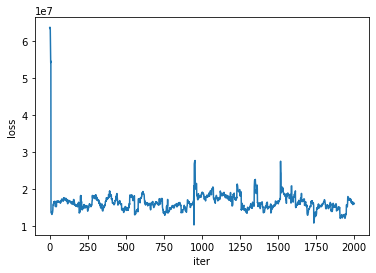

The time of execution of above program is : 458.0382037162781
theta for imputation error:  [array([1.46004489]), array([2.32183232])]


In [18]:
start = time.time()
theta1,theta2,theta,loss_list = SGD(predicted_r_1d, observed_e_1d, propensities_1d, step_size = 0.0001)
end = time.time()
    
print("The time of execution of above program is :", end-start)
print("theta for imputation error: ", theta)

## Factor Machine using Tensorflow

In [19]:
from itertools import count # 迭代器
from collections import defaultdict # 使用dict时，如果引用的Key不存在，就会抛出KeyError。如果希望key不存在时，返回一个默认值，就可以用defaultdict
from scipy.sparse import csr # csr_matrix，全名为Compressed Sparse Row，是按行对矩阵进行压缩的。CSR需要三类数据：数值，列号，以及行偏移量。CSR是一种编码的方式，其中，数值与列号的含义，与coo里是一致的。行偏移表示某一行的第一个元素在values里面的起始偏移位置。 
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tqdm import tqdm_notebook as tqdm # 可以显示循环的进度条的库

Instructions for updating:
non-resource variables are not supported in the long term


待完成：
注意！此处x_train, y_train需要替换成做所有的useritem pair features

In [20]:
x_train = observation_matrix.astype(np.float32)
y_train = np.array(observed_r).flatten().astype(np.float32)

In [34]:
x_train.shape

(1586126, 20)

In [21]:
theta = np.array(theta).astype(np.float32)

In [23]:
def vectorize_dic(dic, ix=None, p=None):
    """ 
    Creates a scipy csr matrix from a list of lists (each inner list is a set of values corresponding to a feature) 
    
    parameters:
    -----------
    dic -- dictionary of feature lists. Keys are the name of features
    ix -- index generator (default None)
    p -- dimension of featrure space (number of columns in the sparse matrix) (default None)
    """
    if (ix == None):
        d = count(0)
        ix = defaultdict(lambda: next(d)) 
        
    n = len(list(dic.values())[0]) # num samples
    g = len(list(dic.keys())) # num groups
    nz = n * g # number of non-zeros

    col_ix = np.empty(nz, dtype=int)     
    
    i = 0
    for k, lis in dic.items():     
        # append index el with k in order to prevet mapping different columns with same id to same index
        col_ix[i::g] = [ix[str(el) + str(k)] for el in lis]
        i += 1
        
    row_ix = np.repeat(np.arange(0, n), g)      
    data = np.ones(nz)
    
    if (p == None):
        p = len(ix)
        
    ixx = np.where(col_ix < p)

    return csr.csr_matrix((data[ixx],(row_ix[ixx], col_ix[ixx])), shape=(n, p)), ix

cols = ['user','item','rating','timestamp']

#train = pd.read_csv('ml-100k/ua.base',delimiter='\t',names = cols)
#test = pd.read_csv('ml-100k/ua.test',delimiter='\t',names = cols)

#x_train,ix = vectorize_dic({'users':train['user'].values,  'items':train['item'].values})

#x_test,ix = vectorize_dic({'users':test['user'].values,   'items':test['item'].values},ix,x_train.shape[1])
#print(x_train)
#y_train = train['rating'].values
#y_test = test['rating'].values

#x_train = x_train.todense() # toarray returns an ndarray; todense returns a matrix. If you want a matrix, use todense otherwise, use toarray
#x_test = x_test.todense()


In [24]:
def batcher(X_, y_=None, batch_size=-1):
    n_samples = X_.shape[0]

    if batch_size == -1:
        batch_size = n_samples
    if batch_size < 1:
       raise ValueError('Parameter batch_size={} is unsupported'.format(batch_size))

    for i in range(0, n_samples, batch_size):
        upper_bound = min(i + batch_size, n_samples)
        ret_x = X_[i:upper_bound]
        ret_y = None
        if y_ is not None:
            ret_y = y_[i:i + batch_size]
            yield (ret_x, ret_y)


In [52]:
n,p = x_train.shape

k = 10

x = tf.placeholder('float',[None,p])

y = tf.placeholder('float',[None,1])

O_ui = tf.Variable(O_mask_1d.astype(np.float32))
P_ui = tf.Variable(np.array(propensities).flatten().astype(np.float32))

w0 = tf.Variable(tf.ones([1]))
w = tf.Variable(tf.zeros([p]))

v = tf.Variable(tf.random_normal([k,p],mean=0,stddev=0.005))

#y_hat = tf.Variable(tf.zeros([n,1]))

linear_terms = tf.add(w0,tf.reduce_sum(tf.multiply(w,x),1,keep_dims=True)) # n * 1
pair_interactions = 0.5 * tf.reduce_sum(
    tf.subtract(
        tf.pow(
            tf.matmul(x,tf.transpose(v)),2),
        tf.matmul(tf.pow(x,2),tf.transpose(tf.pow(v,2)))
    ),axis = 1 , keep_dims=True)

y_hat = tf.add(linear_terms,pair_interactions)

In [53]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(y_hat, feed_dict={x: x_train.reshape(-1,p), y: y_train.reshape(-1,1)}))

[[1.0242944]
 [1.0223879]
 [1.0125345]
 ...
 [4.4368935]
 [4.4459767]
 [4.450598 ]]


In [27]:
lambda_w = tf.constant(0.001,name='lambda_w')
lambda_v = tf.constant(0.001,name='lambda_v')

l2_norm = tf.reduce_sum(
    tf.add(
        tf.multiply(lambda_w,tf.pow(w,2)),
        tf.multiply(lambda_v,tf.pow(v,2))
    )
)

imputed_error = tf.reduce_sum(tf.multiply(theta[0],tf.square(y_hat - theta[1])))
inner = tf.subtract(tf.subtract(y, y_hat), imputed_error)
error = tf.divide(tf.add(imputed_error, tf.multiply(O_ui, inner)), P_ui)
# error = tf.reduce_mean(tf.square(y-y_hat))
loss = tf.add(error,l2_norm)

train_op = tf.train.GradientDescentOptimizer(learning_rate=0.000001).minimize(loss)

In [36]:
epochs = 5
batch_size = 1000

# Launch the graph
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    for epoch in tqdm(range(epochs), unit='epoch'):
        sess.run(train_op, feed_dict={x: x_train, y: y_train.reshape(-1,1)})
        print(sess.run(loss, feed_dict={x: x_train,y: y_train.reshape(-1,1)}))

    print(sess.run(y_hat, feed_dict={x: x_train, y: y_train}))


/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/5 [00:00<?, ?epoch/s]

ResourceExhaustedError: OOM when allocating tensor with shape[1586126,1586126] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[node Mul_5 (defined at /Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'Mul_5':
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 442, in run_forever
    self._run_once()
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 1462, in _run_once
    handle._run()
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 532, in <lambda>
    self.io_loop.add_callback(lambda: self._handle_events(self.socket, 0))
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 448, in _handle_events
    self._handle_recv()
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 477, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-9ce7d9113838>", line 13, in <module>
    error = tf.divide(tf.add(imputed_error, tf.multiply(O_ui, inner)), P_ui)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/ops/math_ops.py", line 331, in multiply
    return gen_math_ops.mul(x, y, name)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_math_ops.py", line 6701, in mul
    "Mul", x=x, y=y, name=name)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py", line 793, in _apply_op_helper
    op_def=op_def)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3360, in create_op
    attrs, op_def, compute_device)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3429, in _create_op_internal
    op_def=op_def)
  File "/Users/liuziyu/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 1751, in __init__
    self._traceback = tf_stack.extract_stack()
